# Zathura

I was recently approached by a friend with a question about solving an interesting combinatorial mathematical puzzle. Given a series of squares on a board of dimensions `W x H`, how many possible (non-duplicate) quadrilaterals may be formed by selecting four vertices? Here are the rules (I cannot depict the actual plays in markdown, but I can simulate them with tables):

  - Four points must be chosen, i.e...
  
| col 1 | col 2 | col 3 | col 4 |
|-------|-------|-------|-------|
|       |       |       |   X   |
|       |   X   |       |       |
|       |   X   |       |   X   |
  
  - They must form a quadrilateral (i.e., not a triangle&mdash;so the previous example is valid, but the following is not):
  
| col 1 | col 2 | col 3 | col 4 |
|-------|-------|-------|-------|
|       |       |       |   X   |
|       |       |   X   |       |
|       |   X   |       |   X   |

Quadrilaterals are extremely diverse in nature, and can be difficult to detect. For instance, all of the following are valid (of course, the quadrilaterals with crossing lines can and will be represented as squares for this game&mdash;there are no rules about facets):

<img src="img/quad.png" alt="Quadrilaterals"/>

__Theorem: *In order to determine whether or not a play is a quadrilateral, we must only validate that 3 or more points do not fall on a line segment (lest the play be deemed a triangle or line, respectively)*__

In [9]:
import numpy as np

# for continuity's sake
print("Numpy version: %s" % np.__version__)

Numpy version: 1.12.1


This is a combinatorial problem with some strategic filtering involved in the end. There will be two ways to solve this:

  1. __Brute force__: design every possible play, filter duplicates and illegal moves
  2. __Algorithmic__: design an equation that computes the number of legal plays given the input dimensions.
  
## Brute Force approach
  
First, we'll solve the brute force method to have a baseline against which to compare the time and outputs of the equation. Both ways, we'll need several utility functions:

In [10]:
w = 15
h = 10

# since this is a combinatorial problem, we need to know how many ways there are to select
# W * H vertices. We'll use the following function:
def n_choose_k(n, k):
    return np.math.factorial(n) / (np.math.factorial(k) * np.math.factorial(n - k))

# This is the number of possible selections:
print("Possible (non-filtered) quadrilaterals: {:,}".format(n_choose_k(15 * 10, 4)))

Possible (non-filtered) quadrilaterals: 20,260,275


That's a *ton* of possibilities and, frankly, impossible to validate. So for the brute force method, let's solve a `3x3` square (so `2x2` squares with `3x3` vertices) and then extrapolate to our `15x10`. First let's define a few more utility functions and classes... the `Play` class accepts four geometric points and provides utilites for determining whether or not the play is valid. The algorithm we'll use to determine validity is relatively simple:

    For each triplet, T, within the set of 4:
        Determine that T does not form a line segment
                
This gets very simple if you think of the triplet as two vectors (jointly unified with the middle point) and compute the cosine similarity between the two vectors:

$$cossim(\mathrm{a}, \mathrm{b}) = cos(\theta_{\mathrm{a} \mathrm{b}}) = \frac{\mathrm{a} \cdot \mathrm{b}}{\left \| \mathrm{a} \right \| \left \| \mathrm{b} \right \|}$$

Cosine similarity measures the cosine of angle ${\theta}$ between two vectors (i.e., the magnitude). The ${cossim}$ will be bound in ${[-1, 1]}$; if ${cossim}$ is equal to 0, it means the vectors are orthogonal (i.e., 90 degrees and do not form a line). If the ${cossim}$ is 1, it means the vectors are the same, and if it's -1, it means they are perfectly opposite, i.e., they are in a perfect line&mdash;*this is our answer!* If any of the triplets' ${cossim}$ is equal to -1, it means there is a line segment contained in our play, and it is illegal.

In [62]:
w = 3
h = 3

In [263]:
from itertools import combinations
from matplotlib import pyplot as plt
%matplotlib inline

def _almost_equals(a, b, eps=1e-3):
    return np.abs(a - b) <= eps

def _cos_sim3(x, y, z):
    a = np.asarray([x[0] - y[0], x[1] - y[1]])
    b = np.asarray([x[0] - z[0], x[1] - z[1]])

    # compute the cosine similarity
    return a.dot(b) / (np.sqrt(a.dot(a)) * np.sqrt(b.dot(b)))

def _forms_line_segment(x, y, z):
    cs = _cos_sim3(x, y, z)

    # abs is unnecessary, as we know the points will be unique (and not the same vector)
    # but still good just in case someone misuses this class...
    return _almost_equals(np.abs(cs), 1.0)

class Play(object):
    """The `Play` class accepts four tuples, which
    represent cartesian points, and provides utility
    methods that determine the play's validity.
    """
    def __init__(self, a, b, c, d):
        self.a = a
        self.b = b
        self.c = c
        self.d = d
        
    def __eq__(self, other):
        return hash(self) == hash(other)
        
    def __hash__(self):
        # this is a hack that exploits the commutative nature of XOR. Identical
        # (but re-ordered) points will share the same hashcode and can be computed
        # with relative ease/efficiency. We can also cache it to make it faster.
        if hasattr(self, 'hash_'):
            return self.hash_
        self.hash_ = hash(self.a) ^ hash(self.b) ^ hash(self.c) ^ hash(self.d)
        return self.hash_
    
    def is_valid(self):
        # for each set of 3 vertices within the set of 4 (4 possibilities - n_choose_k(4, 3))
        # determine that no triplets form a line segment.
        for x, y, z in combinations([self.a, self.b, self.c, self.d], 3):
            if _forms_line_segment(x, y, z):
                return False
            
        # if we get here, we know it's valid
        return True
    
    def show(self):
        pts = [self.a, self.b, self.c, self.d]
        x, y = zip(*pts)
        scatter = plt.scatter(x=x, y=y)
        plt.show()

Let's test out the above class for some corner cases:

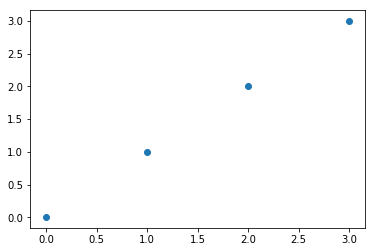

Is play valid: False


In [264]:
# Let's try a line segment
play = Play((0,0), (1,1), (2,2), (3,3))
play.show()

# this should NOT be a valid play:
print("Is play valid: %r" % play.is_valid())

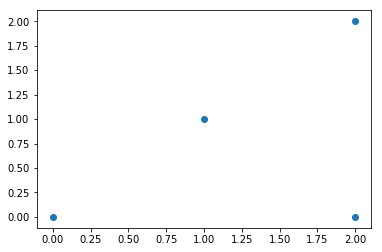

Is play valid: False


In [265]:
# Let's try a triangle
play = Play((0,0), (1,1), (2,2), (2,0))
play.show()

# this should NOT be a valid play:
print("Is play valid: %r" % play.is_valid())

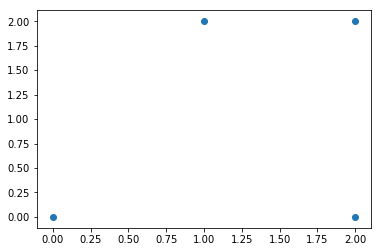

Is play valid: True


In [266]:
# Let's show a valid play, now.
play = Play((0,0), (1,2), (2,2), (2,0))
play.show()

# this SHOULD be a valid play:
print("Is play valid: %r" % play.is_valid())

In [177]:
# Let's show that the same play in a different order is the same hash code...
assert Play((0,0), (1,1), (2,2), (2,0)) == Play((1,1), (2,2), (2,0), (0,0))

# Let's show that different plays have a different hash code...
assert Play((0,0), (1,1), (2,2), (2,0)) != Play((1,1), (2,2), (2,0), (1,2))

# show that the same plays (with differing orders) will only occupy one slot in a hash table:
assert len(set([Play((0,0), (1,1), (2,2), (2,0)), Play((1,1), (2,2), (2,0), (0,0))])) == 1

### Building all possible plays

Now that we have a robust class that can estimate the validity of a play and whether it's equal to another, we need to build all possible plays and store them in a set (the hash code hack will ensure only non-duplicates will be stored).

In [274]:
# first, generate a list of all possible coordinates
coordinates = [(i, j) for i in range(h) for j in range(w)]

# now generate combinations of 4...
all_possible_plays = [Play(*args) for args in combinations(coordinates, 4)]

# See how many there are...
nc4 = n_choose_k(len(coordinates), 4)
assert len(all_possible_plays) == nc4
print(("Number of possible plays for %i x %i: {:,}" % (h, w)).format(nc4))

Number of possible plays for 3 x 3: 126


### Filtering out illegal plays and duplicates

Now that we have the list of all possible plays, we can easily filter out duplicates and illegal (i.e., triangle or line-segment) plays:

In [276]:
n_legal = len([play for play in all_possible_plays if play.is_valid()])
print("Number of legal plays: {:,}".format(n_legal))

Number of legal plays: 78


## Modularizing the code

Let's make the code much more modular/functional for testing different dimensions:

Number of possible plays for 3 x 3: 78
Completed in 0.007 seconds

Number of possible plays for 5 x 5: 9,498
Completed in 0.617 seconds

Number of possible plays for 7 x 7: 173,663
Completed in 11.237 seconds

Number of possible plays for 9 x 9: 1,393,114
Completed in 84.282 seconds

Number of possible plays for 11 x 11: 7,179,629
Completed in 430.477 seconds



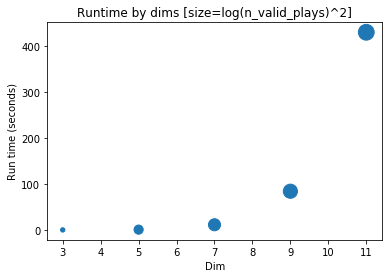

In [278]:
import time


# a decorator utility for timing the function
def timed(func):
    def wrapper(*args, **kwargs):
        start = time.time()
        res = func(*args, **kwargs)
        runtime = time.time() - start
        print("Completed in %.3f seconds\n" % runtime)
        return res, runtime
    return wrapper


@timed
def get_n_possible_plays(w, h):
    """Compute the number of possible plays given the number
    of vertices in the matrix.
    
    Parameters
    ----------
    w : int
        The number of vertices on the X (horizonal) axis.
        
    h : int
        The number of vertices on the Y (vertical) axis.
    """
    # first, generate a list of all possible coordinates
    coordinates = [(i, j) for i in range(h) for j in range(w)]
    
    # make a generator (not evaluated yet) of all the plays so we can
    # evaluate everything in one pass of n choose k
    plays = (Play(*args) for args in combinations(coordinates, 4))

    # See how many there are...
    valid_unique = [play for play in plays if play.is_valid()]
    res = len(valid_unique)
    print(("Number of possible plays for %i x %i: {:,}" % (h, w)).format(res))
    return res
    
# test out our function on some combos:
def report_n_possible_plays(combos):
    brute_res_runtimes = [get_n_possible_plays(*combo) for combo in combos]

    # let's view the runtimes:
    s, y = zip(*brute_res_runtimes)  # res, runtime
    s = np.log(np.asarray(s))**2
    scatter = plt.scatter(x=zip(*combos)[0], y=y, s=s)
    plt.title("Runtime by dims [size=log(n_valid_plays)^2]")
    plt.xlabel("Dim")
    plt.ylabel("Run time (seconds)")
    plt.show()
    
report_n_possible_plays([(3, 3), (5, 5), (7, 7), (9, 9), (11, 11)])

With this diagram, you can see the major drawback of our current solution... *it takes __forever__*! And it scales polynomially (at `O(N-choose-4)`, to be specific). This would be unacceptable compute time if we were computing this online or on a phone. So there must be a better way to do it... in the next section, we'll pursue a more algorithmic approach that can compute the appropriate number of unique, valid plays just given `w` and `h`.

## Algorithmic approach

There are several things we need to consider when developing an algorithmic approach:

  1. Create a rule, ${t}$, for the number of line segments/triangles that will be formed in a grid with respect to the `w`, `h` dims.
  2. Create a rule, ${p}$, for computing the number of all possible (*unique*) vertex combinations of 4 (equal to n_choose_k(w * h, 4)).
  3. The answer should be: $$p(w, h) - t(w, h)$$

In [288]:
def t(w, h):
    """Compute the number of expected line segments/triangles that will
    be formed in a grid of dimensions `w * h`.
    
    Parameters
    ----------
    w : int
        The number of vertices on the X (horizonal) axis.
        
    h : int
        The number of vertices on the Y (vertical) axis.
    """
    # if any of the dims are 1, the answer is 0. We will raise to make sure user knows their mistake...
    if any(v == 0 for v in (w, h)):
        raise ValueError('Not valid in any dimension == 1')
    
    # the number of all points on the board
    n_points = w * h
    
    # function to compute the number of illegal plays caused by a new row/col/diag
    def _n_segments_for_dim(d):
        # for a single dimension, return the number of expected line segments
        # and triangles possible (ONLY horizontal / vertical). There are several
        # corner cases here...
        # 1. d < 3 - impossible to have any segments in this dim
        # 2. d < 4 - only possible to have triangles in this dim. (fortunately can
        #    handled with the n_choose_k)
        if d < 3:
            return 0
        
        # otherwise there are >= 3 in dim d. Multiply * the number of other available
        # points on the board with which an illegal play could be made
        res = n_choose_k(d, 3) * (n_points - d)
        if d > 3:
            res += n_choose_k(d, 4)
        return res
        
    # sum up the number of illegal plays on the horizontal and vertical axes
    hv_illegal_plays = sum(_n_segments_for_dim(d) * d for d in (w, h))
    
    # now count up the number of illegal plays for diagonal dimensions. This can be
    # a challenge, because we're not guaranteed a square grid. Therefore, we need to
    # generate the diagonal dimensions first.
    min_dim = min(w, h)  # this will be the max length of all of the diagonal vectors
    max_dim = max(w, h)  # length of the max dim, and used for computing n_diagonal vectors
    n_diag_vectors = max_dim + (min_dim - 1)
    
    diag_vectors = []
    trail_len = min_dim - 1  # the length on the pyramid downward
    for i in range(1, n_diag_vectors + 1):
        length = min(i, min_dim)
        
        # if i > max_dim, it's actually -= 1...
        if i > max_dim:
            length = trail_len
            trail_len -= 1
            
        diag_vectors.append(length)
        
    # now compute the number of illegal plays in the diagonals (x2!)
    diag_illegal_plays = 2 * sum(_n_segments_for_dim(d) for d in diag_vectors)
    res = diag_illegal_plays + hv_illegal_plays
        
    # There is one final (major) corner case for illegal plays. Unfortunately it's extremely
    # difficult to account for/compute given solely (w, h). Consider w=5, h=5, and the points:
    # >>> [(0, 1), (2, 2), (4, 3), (x, x)]
    # This forms a triangle across diagonals, and in a very difficult-to-compute way (unless we
    # were to iterate vertices as we did in the brute force method... this is where things get
    # really hard). Note that this only happens when a dimension > 4
    if w > 4 or h > 4:
        ct = 0
        
        # this is a naive solution...
        
        # starting with a gap of 2, create cross-diagonal vectors increasing in slope
        # until slope == 1 (equivalent to plain diagonal vector). This cuts compute
        # time down a lot. We can multiply by 8 to account for reflection above diagonal,
        # horizonal and vertical reflections. This way the original always begins from
        # the left and moves right.
        for y in range(h):  # move down -> up for origin
            for x in range(w):  # move left -> right for origin
                
                # start with run of 2, rise of 1
                for run in range(2, max_dim):
                    if 3 * run > max_dim:
                        break
                    
                    # if rise ever == run, then it's a perfect diagonal...
                    for rise in range(1, run):
                        ct += 1 * (n_points - 3)
                        
                    # if we can make one of len 4...
                    ct += int(4 * run <= max_dim)
                
        res += ct   
    
    return res

# test -- how many illegal plays can we get in a 3x3? (should be 48)
t(5,5)

2888

In [289]:
def p(w, h):
    """Compute the number of possible unique vertex sets of 4 
    that will be formed in a grid of dimensions `w * h`.
    
    Parameters
    ----------
    w : int
        The number of vertices on the X (horizonal) axis.
        
    h : int
        The number of vertices on the Y (vertical) axis.
    """
    return n_choose_k(w * h, 4)


@timed
def n_possible_fast(w, h):
    """Compute the number of possible unique, legal plays 
    in a grid of dimensions `w * h`.
    
    Parameters
    ----------
    w : int
        The number of vertices on the X (horizonal) axis.
        
    h : int
        The number of vertices on the Y (vertical) axis.
    """
    res = p(w, h) - t(w, h)
    print(("(FAST) Number of possible plays for %i x %i: {:,}" % (h, w)).format(res))
    return res

In [290]:
def compare(mx):
    for i in range(2, mx + 1):
        print('-------------------------------------------')
        _ = get_n_possible_plays(i, i)
        _ = n_possible_fast(i, i)
        
compare(6)

-------------------------------------------
Number of possible plays for 2 x 2: 1
Completed in 0.001 seconds

(FAST) Number of possible plays for 2 x 2: 1
Completed in 0.000 seconds

-------------------------------------------
Number of possible plays for 3 x 3: 78
Completed in 0.008 seconds

(FAST) Number of possible plays for 3 x 3: 78
Completed in 0.000 seconds

-------------------------------------------
Number of possible plays for 4 x 4: 1,278
Completed in 0.087 seconds

(FAST) Number of possible plays for 4 x 4: 1,278
Completed in 0.000 seconds

-------------------------------------------
Number of possible plays for 5 x 5: 9,498
Completed in 0.595 seconds

(FAST) Number of possible plays for 5 x 5: 9,762
Completed in 0.000 seconds

-------------------------------------------
Number of possible plays for 6 x 6: 47,097
Completed in 3.044 seconds

(FAST) Number of possible plays for 6 x 6: 47,199
Completed in 0.000 seconds



Now that we are sure our fast method is working and we are confident that it will work in all scenarios, we can compute a much broader array of combinatorics in a much faster manner. Let's replicate the above scenario:

(FAST) Number of possible plays for 3 x 3: 78
Completed in 0.000 seconds

(FAST) Number of possible plays for 5 x 5: 9,762
Completed in 0.000 seconds

(FAST) Number of possible plays for 7 x 7: 179,354
Completed in 0.000 seconds

(FAST) Number of possible plays for 9 x 9: 1,483,425
Completed in 0.000 seconds

(FAST) Number of possible plays for 11 x 11: 7,858,719
Completed in 0.001 seconds



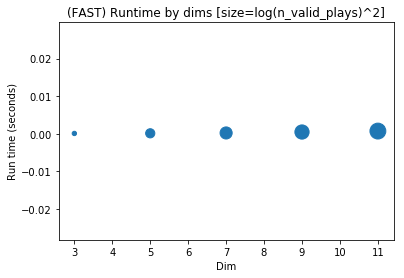

In [291]:
# test out our function on some combos:
def fast_report_n_possible_plays(combos):
    res_runtimes = [n_possible_fast(*combo) for combo in combos]

    # let's view the runtimes:
    s, y = zip(*res_runtimes)  # res, runtime
    s = np.log(np.asarray(s))**2
    scatter = plt.scatter(x=zip(*combos)[0], y=y, s=s)
    plt.title("(FAST) Runtime by dims [size=log(n_valid_plays)^2]")
    plt.xlabel("Dim")
    plt.ylabel("Run time (seconds)")
    plt.show()
    
fast_report_n_possible_plays([(3, 3), (5, 5), (7, 7), (9, 9), (11, 11)])

Notice the new runtime is nearly constant! We can now compute must larger ranges:

(FAST) Number of possible plays for 15 x 15: 99,185,286
Completed in 0.003 seconds

(FAST) Number of possible plays for 16 x 16: 167,723,288
Completed in 0.003 seconds

(FAST) Number of possible plays for 17 x 17: 274,440,265
Completed in 0.003 seconds

(FAST) Number of possible plays for 18 x 18: 435,718,017
Completed in 0.004 seconds

(FAST) Number of possible plays for 19 x 19: 675,185,121
Completed in 0.003 seconds



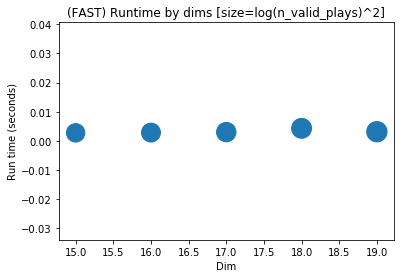

In [292]:
fast_report_n_possible_plays([(i, i) for i in range(15, 20)])

## Final answer

The original question was in regards to a 15 X 10 grid. Now that we have a fast solution, we can compute this:

In [293]:
_ = n_possible_fast(15, 10)

(FAST) Number of possible plays for 10 x 15: 18,602,949
Completed in 0.002 seconds

